# Introduction to statistical language models

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import datasets
from datasets import load_dataset

In [3]:
datasets.logging.set_verbosity_error()

## Empathetic dialogues
Provides promts and utterances from dialogues in different emotional contexts.
[Dataset link](https://huggingface.co/datasets/empathetic_dialogues)

In [4]:
dataset = load_dataset("empathetic_dialogues")

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
X = pd.DataFrame(dataset['train'])

In [6]:
X.head(2)

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,


# Language model of emotional contexts
In this example, we try to build a LM for each of the emotional contexts, in order to explore three main aspects of LMs:
- how word prediction changes with different models
- how a model can be used to generate a text
- how a model can be used to classify a text

In [7]:
X.context.unique()

array(['sentimental', 'afraid', 'proud', 'faithful', 'terrified',
       'joyful', 'angry', 'sad', 'jealous', 'grateful', 'prepared',
       'embarrassed', 'excited', 'annoyed', 'lonely', 'ashamed', 'guilty',
       'surprised', 'nostalgic', 'confident', 'furious', 'disappointed',
       'caring', 'trusting', 'disgusted', 'anticipating', 'anxious',
       'hopeful', 'content', 'impressed', 'apprehensive', 'devastated'],
      dtype=object)

In [8]:
X.shape

(76673, 8)

## Documents tokenizer and padding
Padding is a strategy for ensuring sentences have the same size in terms of tokens by adding a special padding token to shorter sentences.

Note that BERT tokenizers have a maximum sequence length. Thus, we need to split the text composed by more then the maximum number of chars.

We create a unique dataset of text blocks and we keep an index of the corresponding emotion.

We also exploit the capability of BERT to tokenize pair of sentences. See [https://huggingface.co/transformers/v3.0.2/preprocessing.html](https://huggingface.co/transformers/v3.0.2/preprocessing.html)

**Summary of our pre-processing strategy**
- we keep the prompt as is
- we split the utterance in several sentences
- for each utterance sentence, we create a pair (prompt, sentence)
- we tokenize the pair by **Padding** and **Truncating**

In [9]:
from transformers import AutoTokenizer
from nltk.tokenize import sent_tokenize

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [11]:
contexts, prompts, utterances = X.context.values, X.prompt.values, X.utterance.values
batch_prompts, batch_utterances, batch_contexts = [], [], []

for i, c in enumerate(contexts):
    p, u = prompts[i], utterances[i]
    batch_prompts.append(p)
    batch_utterances.append(u)
    batch_contexts.append(c)

### Balance and filter
Here, we compose a dataset by selecting sample of emotional contexts, in order to ensure balance and keep the example simple.

In [12]:
from collections import Counter

In [13]:
emotions = pd.DataFrame(Counter(batch_contexts).most_common())#.head(6)
E = set(emotions[0])
sample_prompts, sample_utterances, sample_contexts = [], [], []
for i, c in enumerate(batch_contexts):
    if c in E:
        sample_contexts.append(c)
        sample_prompts.append(batch_prompts[i])
        sample_utterances.append(batch_utterances[i])
print(len(sample_contexts))

76673


### Tokenize

In [14]:
encoded_inputs = tokenizer(
    sample_prompts, sample_utterances, truncation=True, padding=True)['input_ids']

### Show the first 6 tokens of a sentence and how the decoder works

In [15]:
sentence_id = 0
print(sample_prompts[sentence_id], sample_utterances[sentence_id], '\n')
print('tokens', '=>', encoded_inputs[sentence_id][:6])
decoded_text = tokenizer.decode(encoded_inputs[sentence_id])
print('decoded', '=>', decoded_text[:decoded_text.index('[PAD]')+12], '...')

I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world. I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world. 

tokens => [101, 146, 2676, 1280, 1106, 1103]
decoded => [CLS] I remember going to the fireworks with my best friend. There was a lot of people _ comma _ but it only felt like us in the world. [SEP] I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people _ comma _ we felt like the only people in the world. [SEP] [PAD] [PAD]  ...


In [16]:
def decode(encoded_text):
    decoded_text = tokenizer.decode(encoded_text)
    if '[PAD]' in decoded_text:
        text = decoded_text[:decoded_text.index('[PAD]')+12]
    else:
        text = decoded_text
    return text

### Create sub-corpora for emotional clusters

In [17]:
emotions = {
    'Profile A': {'caring', 'nostalgic', 'sentimental'},
    'Profile B': {'angry', 'disappointed', 'furious'},
    'Profile C': {'content', 'excited', 'grateful'}
}

In [18]:
def get_corpus(emotions, contexts, encoded_docs):
    data = []
    for i, context in enumerate(contexts):
        if context in emotions:
            data.append(encoded_docs[i])
    return data

In [19]:
corpora = dict([
    (profile, get_corpus(emotions[profile], sample_contexts, encoded_inputs)) for profile in emotions.keys()])

In [20]:
for k, v in corpora.items():
    print(k, len(v))

Profile A 6477
Profile B 7490
Profile C 7637


In [21]:
corpora['Profile A'][0][:4]

[101, 146, 2676, 1280]

## Statistical language models: n-gram models

A n-gram is a chunk of consecutive words.
    
    * unigrams:  time, flies, like, an, arrow
    * bigrams:   (time, flies), (flies, like), (like, an), (an, arrow)
    * trigrams:  (time, flies, like), (flies, like, an), (like, an, arrow)
    * 4-grams:   (time, flies, like, an), (flies, like, an, arrow)

N-gram language model estimates conditional probability of the next word
by collecting n-gram counts from a text corpus.

$$ P(w_{t+1}| w_1, .., w_{t} ) = \frac{count (w_1, .., w_{t}, w_{t+1})}{count( w_1, .., w_{t})}  $$


**Simplifying assumption**

The n-gram model assumes that the probability of a word (gram) depends only on preceding n - 1 words.
A 3-gram language model approximates conditional probabilities as follows:

$$ P(\text{ Time flies like an arrow} ) 
= P(\text{ Time } ) · P(\text{ flies }|\text{ Time } ) · P(\text{ like }| \text{ Time flies }) · P(\text{ an } | \text{  flies like } ) · P(\text{ arrow } | \text{ like an } ) $$


**Smoothing and backoff**

Cases of zeros at denominator or numerator: 
* Avoid zeros in the numerator, by adding 1, or some small quantity to all ngram counts. (laplace smoothing)
  Smoothing is used to give some probability to unseen ngrams.  
* If a prefix has not been observed, a zero at denominator will prevent you from computing the probability:
  the only solution is to backoff to shorter ngram prefix.


### Indexing

In [22]:
from models import NGramModel
from nltk import ngrams

In [23]:
example = [101, 2903, 143, 245]
print(list(ngrams(example, n=3, pad_left=True)))

[(None, None, 101), (None, 101, 2903), (101, 2903, 143), (2903, 143, 245)]


In [24]:
corpus = corpora['Profile A']
profile_models = NGramModel(n=3)
profile_models.count_ngrams([[x for x in y if x != 0] for y in corpus])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6477/6477 [00:00<00:00, 23859.51it/s]


In [25]:
prefix = tokenizer('I remember')['input_ids'][:-1]
log_p = pd.Series(profile_models.compute_log_prob(prefix))
for k, v in log_p.sort_values(ascending=False).head().items():
    print(k, decode([k]), v)

1165 when -1.0213964380007265
1103 the -1.9832976811269338
1139 my -2.070309058116563
1155 all -3.244428899292818
1280 going -3.244428899292818


In [26]:
next_token = profile_models.sample_next(prefix)
decode([next_token])

'the'

### Generate text for different emotions

In [27]:
models = dict([(profile, NGramModel(n=3)) for profile in corpora.keys()])
for profile, model in models.items():
    model.count_ngrams([[x for x in y if x != 0] for y in corpora[profile]])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7637/7637 [00:00<00:00, 24890.34it/s]


In [28]:
def generate(profile, start_word):
    start, eos = 101, 102
    start_prefix = tokenizer(start_word)['input_ids'][1]
    prefix = [start, start_prefix]
    for i in range(100):
        next_token = models[profile].sample_next(prefix)
        if next_token == eos:
            break
        else:
            prefix.append(next_token)
    return prefix

In [35]:
for profile in corpora.keys():
    text = generate(profile, start_word="I")
    print(profile, ' : ', ", ".join(emotions[profile]))
    print(decode(text), '\n')

Profile A  :  sentimental, caring, nostalgic
[CLS] I just got the news about my parents attic. It's the home to give her emotional support by taking her to know where that kept having strokes due to his job at the animal shelter. It brought back so many memories. 

Profile B  :  disappointed, furious, angry
[CLS] I wanted them to a job I applied for a break between. 

Profile C  :  excited, content, grateful
[CLS] I am sure that it was nice to have that. I can finally have a regular full - time job I felt very appreciative of the season start? 



### Compute probabilities for classification purposes
This test is made on the training set. Try to run this on the test set to verify how generalizing terminology is an issue for the model.

In [36]:
from nltk import ngrams

**Example**

In [64]:
sentence = tokenizer('i wish i was looking through old pictures')['input_ids']
model = models['Profile C']
p = None
for chunk in ngrams(sentence, n=3, pad_left=True, left_pad_symbol=102):
    prefix = chunk[-3:-1]
    probs = model.compute_log_prob(prefix)
    final_word = chunk[-1]
    try:
        estimation = probs[final_word]
        if estimation != 0:
            if p is None:
                p = estimation
            else:
                p += estimation
    except KeyError:
        pass

In [65]:
p

-6.1446409152384085

In [67]:
def predict(profile, sentence_text):
    sentence = tokenizer(sentence_text)['input_ids']
    model = models[profile]
    return model.eval_prob(sentence)

def predict_tokens(profile, sentence):
    model = models[profile]
    return model.eval_prob(sentence)

In [68]:
predict('Profile A', 'i wish i was looking through old pictures')

-2.9932848365775113

### Classify

In [69]:
y_true, y_pred = [], []
profiles = list(corpora.keys())
run = list(corpora.items())
for profile, corpus in tqdm(run):
    for sentence in corpus:
        s = [x for x in sentence if x != 0]
        predictions = [predict_tokens(p, s) for p in profiles]
        y_pred.append(profiles[np.argmax(predictions)])
        y_true.append(profile)

  0%|          | 0/3 [00:00<?, ?it/s]

### Evaluation

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [71]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

   Profile A       0.44      0.58      0.50      6477
   Profile B       0.52      0.49      0.51      7490
   Profile C       0.54      0.42      0.48      7637

    accuracy                           0.50     21604
   macro avg       0.50      0.50      0.49     21604
weighted avg       0.51      0.50      0.49     21604



In [72]:
import matplotlib.pyplot as plt

In [73]:
cm = confusion_matrix(y_true, y_pred, labels=profiles)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=profiles)

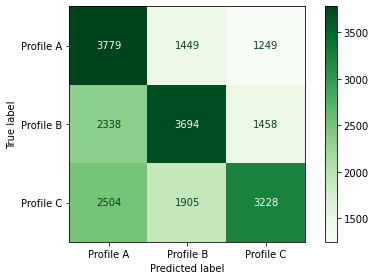

In [74]:
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

## Perplexity
Perlexity is the inverse of corpus probability.

$$ Perplexity = e^{H(p)} = e^{-\sum_x{p(x) \ln p(x)}} $$

In [75]:
from itertools import islice

In [76]:
def compute_perplexity(model, dataset, max_iterations=1000):
    entropy = 0
    num_words, num_iter = 0, 0
    for i in range(max_iterations):
        for sentence in islice(dataset, max_iterations):
            sentence = [x for x in sentence if x != 0]
            prefix = [sentence[1]]
            for token in sentence[2:]:
                try:            
                    log_probs = model.compute_log_prob(prefix) 
                    entropy += log_probs[token]                 
                except KeyError:
                    entropy -= 100
                prefix.append(token)
                num_words += 1
    mean_entropy = entropy / num_words
    return np.exp(mean_entropy)

In [77]:
for profile in profiles:
    print(profile, ' : ', compute_perplexity(models[profile], corpora[profile], max_iterations=50))

Profile A  :  0.02361161425393916
Profile B  :  0.027951038947676452
Profile C  :  0.016482635134495247
